# Import data & libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, RobertaForSequenceClassification
from tqdm import tqdm

In [ ]:
PROJECT_ROOT = Path(__file__).resolve().parent.parent

In [ ]:
data_path = PROJECT_ROOT / "DATA"
output_path = PROJECT_ROOT / "OUTPUT"
df = pd.read_csv(data_path / "IMDB_Dataset.csv")

# Data Cleaning + Feature Engineering

In [ ]:
df['review'] = df['review'].str.replace('<br />', '')

In [ ]:
df['length'] = df['review'].str.len() # Review length is based on character count

In [ ]:
df['log_length'] = np.log1p(df['length']) # Taking log values creates normality of distribution; this will be the basis of our analysis
df['length_group'] = pd.qcut(df['log_length'], 3, labels=['short','medium','long']) # Create length groups based on log tertiles

In [ ]:
print('First threshold: ' + str(df[df['length_group'] == 'short']['log_length'].max()))
print('Second threshold: ' + str(df[df['length_group'] == 'medium']['log_length'].max()))

# EDA

In [ ]:
# This produces a histogram of non log transformed review length
df['length'].hist(bins=20, color='#128bb5')

plt.title('IMDB Review Length (not log transformed)')
plt.xlabel('Character count')
plt.ylabel('Frequency')
plt.grid(False)

plt.savefig(output_path / "raw_review_length.png")
plt.show()

In [ ]:
# This creates a histogram of review length (log transformed) with length groups marked off by dashed lines
df['log_length'].hist(bins=20, color='#128bb5')

plt.axvline(x=df[df['length_group'] == 'short']['log_length'].max(), color='#DBA506', linestyle='--', label='First threshold')
plt.axvline(x=df[df['length_group'] == 'medium']['log_length'].max(), color='#DBA506', linestyle='--', label='Second threshold')
plt.title('IMDB Review Length divided by length category')
plt.xlabel('Length (Logarithmic Scale)')
plt.ylabel('Frequency')
plt.grid(False)

plt.savefig(output_path / "log_transformed_review_length.png")
plt.show()

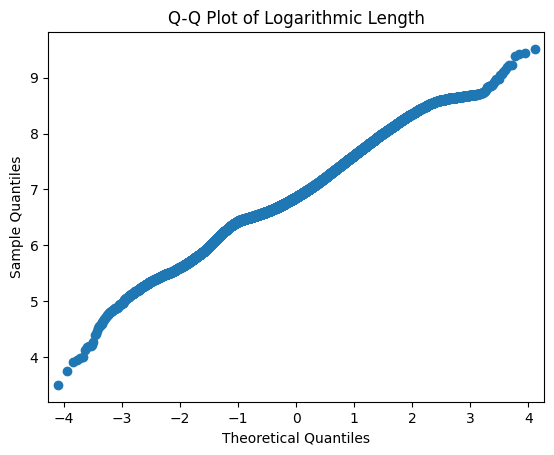

In [ ]:
# This creates a Q-Q plot of logarithmic review length and demonstates the data follows a normal distribution
import statsmodels.api as sm
fig = sm.qqplot(df['log_length'])

plt.title("Q-Q Plot of Logarithmic Length")

plt.savefig(output_path / "q_q_plot.png")
plt.show()

In [ ]:
df.head()

# Sentiment Analysis

In [ ]:

# Set up Roberta model for sentiment analysis
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

torch.set_grad_enabled(False)


# Split long reviews into smaller character chunks.
def chunk_text(text, size=800):
    return [text[i:i+size] for i in range(0, len(text), size)]


# Run a batch of chunks through the model
def roberta_sentiment_batch(chunks):
    inputs = tokenizer(
        chunks,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    probs = F.softmax(outputs.logits, dim=-1)
    scores = probs[:, 2] - probs[:, 0]  # final score = positive score - negative score

    return scores.cpu().numpy().tolist() # Return a list of scores for each chunk


def roberta_severity(text, sentiment_label):
    chunks = chunk_text(text)
    scores = roberta_sentiment_batch(chunks)
    avg_score = float(np.mean(scores))

    if sentiment_label.lower() == "negative":
        return -abs(avg_score)
    return abs(avg_score)


# Run Roberta model on each review
def compute_roberta_severity(df):
    severities = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Scoring reviews"):
        severity = roberta_severity(row["review"], row["sentiment"])
        severities.append(severity)

    df["roberta_severity"] = severities
    return df


In [ ]:
df = compute_roberta_severity(df)
df.head()

In [ ]:
df = df.drop(columns=['sentiment', 'length', 'log_length'])
df.to_csv(data_path / "reviews_with_severity.csv", index=False)